# Script to peform a simple Bayesian inference of mass and concetration from a Navarro-Frenk-White profile to a stack weak lensing data

 The input it is a fit file with
 
 - $R$ [Mpc], 
 - $\Delta\Sigma$ [$M_{\odot} pc^2$], 
 - $\Delta\Sigma_{err}$ [$M_{\odot} pc^2$].
 
 
 The output are the "best" values for mass $(M_{200})$ and concentration $(c)$,
 according to a simple Bayesian inference approach.
 
 The script depends on the NFW.py module from joergdietrich (at Github):
 https://github.com/joergdietrich/NFW/blob/master/nfw.py

In [1]:
#!/bin/env python
#==========================
# author: Maria Elidaiana
# email: mariaeli@cbpf.br
# Script based on: 
# https://github.com/drphilmarshall/StatisticalMethods/blob/b9f481876c002cb210375e07783d6515ed536cca/examples/Cepheids/PeriodMagnitudeRelation.ipynb
#==========================

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM  # The default cosmology is: astropy.cosmology.default_cosmology.get()
from scipy.stats import norm
from nfw import NFW

from astropy.table import Table, vstack      # Use tables instead of recarrays from fits
from time import clock


get_ipython().magic(u'matplotlib inline')
plt.rcParams['figure.figsize'] = (15.0, 9.0)

In [2]:
stacked_clusters = Table.read('./DS_l4/results2fit.fits')
print(stacked_clusters)                      # Check the data

    Radius     Delta_Sigma_T  ...  Delta_Sigma_X  err_Delta_Sigma_X
-------------- -------------- ... --------------- -----------------
           0.1 -113.692461356 ...    150.70816972     230.261760208
 0.12742749857   -119.1124732 ...   149.730147479      196.46117599
0.162377673919  238.645670861 ...  -9.91361205935     123.373471171
0.206913808111  159.940890345 ...   23.2464616234     90.9806852516
0.263665089873  324.025554405 ...   -29.884200742     88.4568157037
0.335981828628  174.054832204 ...   13.3549014394     94.8756435659
0.428133239872  118.912586006 ...   75.5117413139     50.6691236052
0.545559478117  95.8076612929 ...   65.8005899751     36.7545307064
0.695192796178  114.235738068 ...  -23.2264548237     22.9972146552
 0.88586679041  102.016679003 ...   28.6174628011     30.7292777067
 1.12883789168  81.7849838763 ...  -22.5967576614     22.9939347304
 1.43844988829  63.7050603468 ...  -1.82355703144     18.1096541934
 1.83298071083  36.3885016827 ...  -8.9969612327

In [3]:
R     = np.array(stacked_clusters['Radius'])
DSobs = np.array(stacked_clusters['Delta_Sigma_T'])
DSerr = np.array(stacked_clusters['err_Delta_Sigma_T'])

#fitmask = (R>=0.3)&(R<3.5)
fitmask = (R>=0.1)&(R<=10.0) #using all points

print(stacked_clusters[fitmask])

R = R[fitmask]
DSobs = DSobs[fitmask]
DSerr = DSerr[fitmask]
print(R,DSobs)

z_mean = 0.215

    Radius     Delta_Sigma_T  ...  Delta_Sigma_X  err_Delta_Sigma_X
-------------- -------------- ... --------------- -----------------
           0.1 -113.692461356 ...    150.70816972     230.261760208
 0.12742749857   -119.1124732 ...   149.730147479      196.46117599
0.162377673919  238.645670861 ...  -9.91361205935     123.373471171
0.206913808111  159.940890345 ...   23.2464616234     90.9806852516
0.263665089873  324.025554405 ...   -29.884200742     88.4568157037
0.335981828628  174.054832204 ...   13.3549014394     94.8756435659
0.428133239872  118.912586006 ...   75.5117413139     50.6691236052
0.545559478117  95.8076612929 ...   65.8005899751     36.7545307064
0.695192796178  114.235738068 ...  -23.2264548237     22.9972146552
 0.88586679041  102.016679003 ...   28.6174628011     30.7292777067
 1.12883789168  81.7849838763 ...  -22.5967576614     22.9939347304
 1.43844988829  63.7050603468 ...  -1.82355703144     18.1096541934
 1.83298071083  36.3885016827 ...  -8.9969612327

In [4]:
# NFW module that compute the \Delta\Sigma from theory

def DStheo(R, theta):
    m200,c = theta    
    nfw = NFW(m200, c, z_mean, cosmology=FlatLambdaCDM(H0=100, Om0=0.3)) # can change cosmology, overdensity...  
    ds  = nfw.delta_sigma(R)                                             # in units of solMass/Mpc^2
    return np.array(ds.value/1.e12)                                      # in units of solMass/pc^2


#print(DStheo(R, (1e14, 4))) # theta = (m200,c)

In [5]:

# Defining the likelihoods...

def nfw_log_likelihood(R, DSobs, DSerr, theta):
    #print(theta)
    #m200, c = theta
    return -0.5*np.sum(( DSobs - DStheo(R, theta) )**2/(DSerr**2))

def nfw_log_prior(theta, theta_limits):
    
    m200, c = theta 
    
    m200limits, climits = theta_limits
    
    #m200min, m200max = 1e13, 1e15   
    #cmin, cmax = 1, 20
    
    m200min, m200max = theta_limits[0][0], theta_limits[0][1] 
    cmin, cmax = theta_limits[1][0], theta_limits[1][1] 
    
    #print(m200min,m200max)
    #print(cmin,cmax)

    if (m200<m200min)|(m200>m200max):
        log_m200_prior = -np.inf
    else:
        log_m200_prior = 0.0 #-np.log(m200max-m200min)
        
    if (c<cmin)|(c>cmax):
        log_c_prior = -np.inf
    else:
        log_c_prior = 0.0 #-np.log(cmax-cmin)
        
    return log_m200_prior+log_c_prior
    
def nfw_log_posterior(R, DSobs, DSerr, theta, theta_limits):
    m200, c = theta
    return nfw_log_likelihood(R, DSobs, DSerr, theta) + nfw_log_prior(theta, theta_limits)


In [6]:
#Set up contour level plot

def plot_mb_setup(mlimits,climits):
    plt.xlabel('Mass $m200$')
    plt.ylabel('Concetration $c$')
    plt.axis([mlimits[0],mlimits[1], climits[0],climits[1]])
    #plt.xscale('log', nonposx='clip')
    #plt.yscale('log', nonposy='clip')

    
def pdf_contour_levels(p):
    sortp = np.sort(p.ravel())
    cump = sortp.cumsum()
    return [sortp[cump > cump.max() * f].min()
            #for f in [0.32, 0.05]]
            for f in [0.05, 0.32]] #countourplots fucntion must use 95 and 68 conf. level
    
# Set up parameter grids:

npix = 101
m200limits = [1e12, 1e15]
climits = [1, 7]
theta_limits = (m200limits, climits) 

m200grid = np.linspace(m200limits[0], m200limits[1], npix)
#m200grid = np.logspace(np.log10(m200limits[0]), np.log10(m200limits[1]), npix)

cgrid = np.linspace(climits[0], climits[1], npix)

log_posterior = np.zeros((len(m200grid),len(cgrid)))


('Took:', 42.598657, 'seconds')
('Grid maximum posterior values (m200,c) =', 190810000000000.0, 2.98)


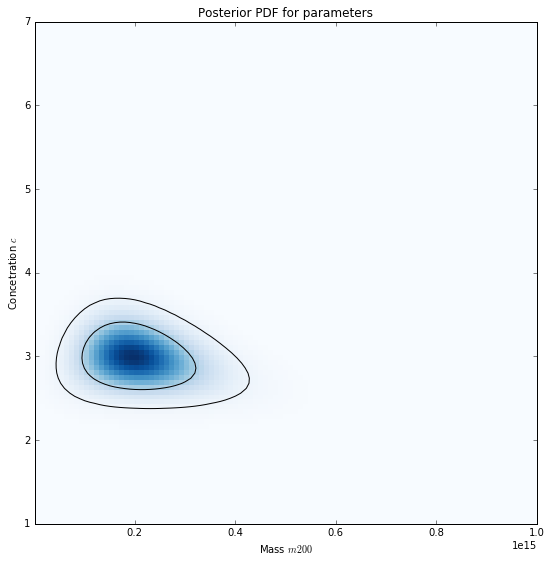

In [7]:
# computing values in the grid....

initial=clock()

# Evaluate log posterior PDF:
for im200,m200 in enumerate(m200grid):
    for ic,c in enumerate(cgrid):
        theta = (m200,c)
        log_posterior[im200,ic] = nfw_log_posterior(R,DSobs,DSerr,theta, theta_limits)

        
final=clock()
print('Took:', final-initial,'seconds')
        
# Convert to probability density and plot, taking care with very small values:

posterior = np.exp(log_posterior - log_posterior.max())


plt.imshow(posterior, extent=[m200limits[0],m200limits[1],climits[0],climits[1]],cmap='Blues',
           interpolation='none', origin='lower', aspect=(m200limits[1]-m200limits[0])/(climits[1]-climits[0]),
           vmin=0, vmax=1)
#plt.contour(np.linspace(m200limits[0], m200limits[1], npix), np.linspace(climits[0], climits[1], npix), posterior, pdf_contour_levels(posterior), colors='k')
plt.contour(m200grid, cgrid, posterior, pdf_contour_levels(posterior), colors='k')


i = np.argmax(posterior)
i,j = np.unravel_index(i, posterior.shape)
print('Grid maximum posterior values (m200,c) =', m200grid[j], cgrid[i])

plt.title('Posterior PDF for parameters')
plot_mb_setup(*theta_limits)

# Plot 1D distributions:

* PDF plots for m200 and c

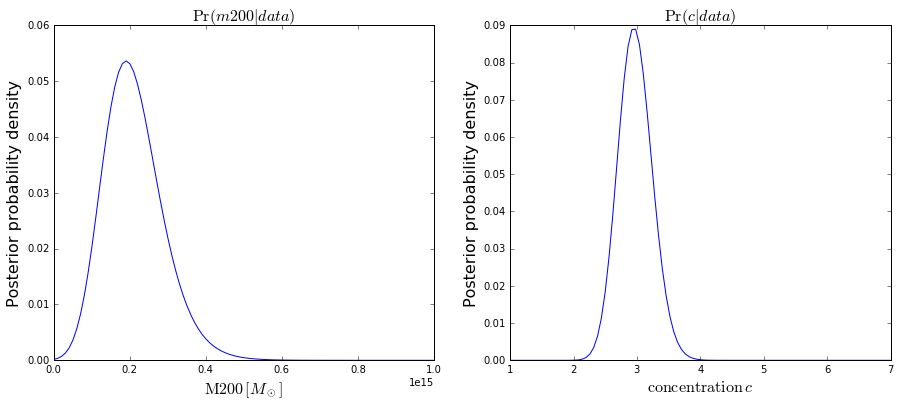

In [8]:
# Normalizing...

prob = posterior
norm = np.sum(prob)
prob /= norm 

prob_m200_given_data = np.sum(prob,axis=0)
prob_c_given_data = np.sum(prob,axis=1)

fig,ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
plt.subplots_adjust(wspace=0.2)

# Plot 1D distributions:

left = ax[0].plot(m200grid, prob_m200_given_data)
ax[0].set_title(r'${\rm Pr}(m200|data)$', fontsize=16)
ax[0].set_xlabel(r'$ {\rm M200} \, [M_\odot]$', fontsize=16)
ax[0].set_ylabel('Posterior probability density', fontsize=16)

right = ax[1].plot(cgrid, prob_c_given_data)
ax[1].set_title(r'${\rm Pr}(c|data)$', fontsize=16)
ax[1].set_xlabel(r'$ {\rm concentration} \, c $', fontsize=16)
ax[1].set_ylabel('Posterior probability density', fontsize=16)
plt.show()


In [9]:
# Determining errors...

def compress_1D_pdf(x,pr,ci=68,dp=1):
    
    # Interpret credible interval request:
    low  = (1.0 - ci/100.0)/2.0    # 0.16 for ci=68
    high = 1.0 - low               # 0.84 for ci=68

    # Find cumulative distribution and compute percentiles:
    cumulant = pr.cumsum()
    pctlow = x[cumulant>low].min()
    median = x[cumulant>0.50].min()
    pcthigh = x[cumulant>high].min()
    
    # Convert to error bars, and format a string:
    errplus = np.abs(pcthigh - median)
    errminus = np.abs(median - pctlow)  

    report = "$ "+str(round(median,dp))+"^{+"+str(round(errplus,dp))+"}_{-"+str(round(errminus,dp))+"} $"

    return [report, median]

print("m200 = ",compress_1D_pdf(m200grid,prob_m200_given_data,ci=68,dp=2)[0])
print("c    = ",compress_1D_pdf(cgrid,prob_c_given_data,ci=68,dp=2)[0])


('m200 = ', '$ 2.008e+14^{+8.991e+13}_{-6.993e+13} $')
('c    = ', '$ 2.98^{+0.24}_{-0.3} $')


In [10]:
# Plotting the curve from inference... 

def plot(R,DS,DSe, DStheo_bf, title, label1, label2, label3):
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(1, 1, 1, yscale='log')
    plt.errorbar(R, DS, yerr=DSe, mec='k', c='k', ls='none', marker='o', mfc='k', ms=5, label=label1)
    plt.plot(R, DStheo_bf, 'r-', label=label3)
    plt.title(title,fontsize=16)
    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    plt.rc('xtick', labelsize=12) 
    plt.rc('ytick', labelsize=12)  
    plt.xlabel(r'$\mathrm{\mathsf{R\,[Mpc]}}$', fontsize=16)
    plt.ylabel(r'$ \Delta\Sigma\,\mathrm{\mathsf{[M_{\odot}pc^2]}}$', fontsize=16)
    #plt.ylim(0.1, 1000)
    plt.xlim(0.3, 4)
    plt.legend(loc='best')  
    plt.show()  
    return

('Probable values from bayesian inference:', 200800000000000.0, 2.98)
('Reduced chi^2 from bayesian inference parameters:', 1.675468026429483)


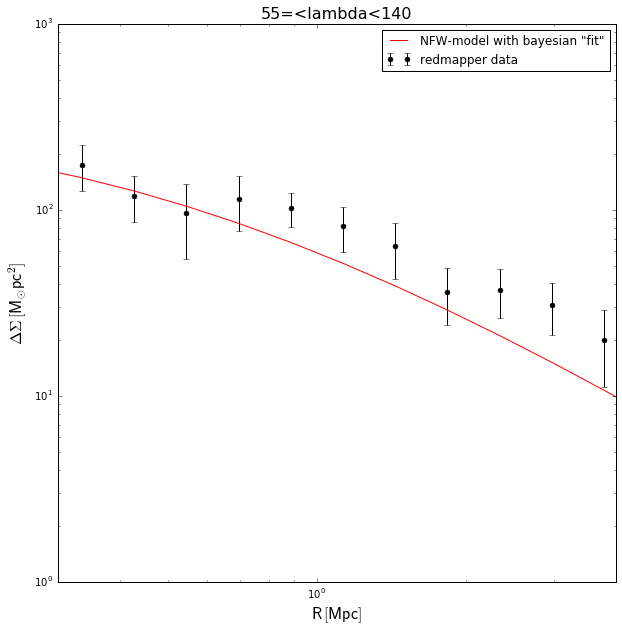

In [11]:
best_m200 = compress_1D_pdf(m200grid,prob_m200_given_data,ci=68,dp=2)[1]
best_c    = compress_1D_pdf(cgrid,prob_c_given_data,ci=68,dp=2)[1] 

#m200grid[j], cgrid[i]

print('Probable values from bayesian inference:', best_m200,best_c)

chisq = ((-1./0.5)*nfw_log_likelihood(R, DSobs, DSerr, (best_m200, best_c)))/(len(R)-2.)
print('Reduced chi^2 from bayesian inference parameters:', chisq)

DStheo_fromfit = DStheo(R, (best_m200,best_c))

plot(R,DSobs,DSerr, DStheo_fromfit, 
     '55=<lambda<140', 'redmapper data', 'NFW-model with nfwsim fit', 'NFW-model with bayesian "fit"')

# MCMC Sampling

* Now we will use MCMC sampling to determine the parameters m200 and c.

* The following piece of code implements the Metropolis algorithm, whose derivation can be read in many textbooks. You can read a brief justification aimed at Phil's grad student self in Chapter 2 of Phil's thesis, for example.


In [12]:
def metropolis(log_posterior, theta, theta_limits, stepsize, nsteps=10000):
    '''
    log_posterior: function of theta 
    theta_limits:  uniform prior ranges
    stepsize:      scalar or vector proposal distribution width
    nsteps:        desired number of samples
    '''
    
    # Start in the center of the prior volume:
    log_prob = log_posterior(R, DSobs, DSerr, theta, theta_limits)
    
    # Store Markov chain as an array of samples:
    chain = np.empty((nsteps, len(theta)))
    log_probs = np.empty(nsteps)
    
    # Count our accepted proposals:
    naccept = 0
    
    for i in range(nsteps):
        
        theta_new = theta + stepsize * np.random.randn(len(theta))
        log_prob_new = log_posterior(R, DSobs, DSerr, theta_new, theta_limits)

        if np.log(np.random.rand()) < (log_prob_new - log_prob):
            # accept, and move to the proposed position:
            theta = theta_new
            log_prob = log_prob_new
            naccept += 1
            
        else:
            # reject, and store the same sample as before:
            pass
        
        chain[i] = theta
        log_probs[i] = log_prob
        
    acceptance_rate = naccept/float(nsteps) 
    
    return chain,log_probs,acceptance_rate

In [13]:

# Initialize m200, c at the center of prior:
m200 = 0.5*(m200limits[0]+m200limits[1])
c = 0.5*(climits[0]+climits[1])
theta = np.array([m200,c])

# Step sizes, 2% or 5% of the prior
m200step = 0.02*(m200limits[1]-m200limits[0])
cstep = 0.02*(climits[1]-climits[0])
stepsize = np.array([m200step,cstep])        
    
# How many steps?
nsteps = 30000
   
print('Running Metropolis Sampler for', nsteps, 'steps...')

initial=clock()
chain, log_probs, acceptance_rate = metropolis(
    nfw_log_posterior, theta, theta_limits, stepsize, nsteps=nsteps
)
final=clock()
print('Acceptance fraction:', acceptance_rate)
print('Took:', final-initial,'seconds')

('Running Metropolis Sampler for', 30000, 'steps...')
('Acceptance fraction:', 0.8161333333333334)
('Took:', 124.61661299999999, 'seconds')


(1, 7)

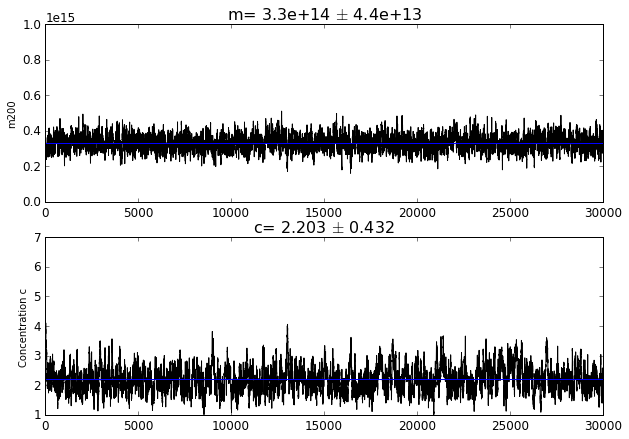

In [14]:
# Pull m and b arrays out of the Markov chain and plot them:
mm = [m for m,c in chain]
cc = [c for m,c in chain]

length=25000 #number of points to average over (must be smaller than the number of steps)

mean_mm = np.mean(mm[-length:])
std_mm = np.std(mm[-length:])
mean_cc = np.mean(cc[-length:])
std_cc = np.std(cc[-length:])

# Traces, for convergence inspection:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.title('m= %.2g $\pm$ %.2g'%(mean_mm,std_mm),fontsize=16)
plt.plot(mm, 'k-')
plt.axhline(np.mean(mm[-length:]))
plt.ylim(m200limits)
plt.ylabel('m200')
plt.subplot(2,1,2)
plt.plot(cc, 'k-')
plt.axhline(np.mean(cc[-length:]))
plt.title('c= %1.3f $\pm$ %1.3f'%(mean_cc,std_cc),fontsize=16)
plt.ylabel('Concentration c')
plt.ylim(climits)

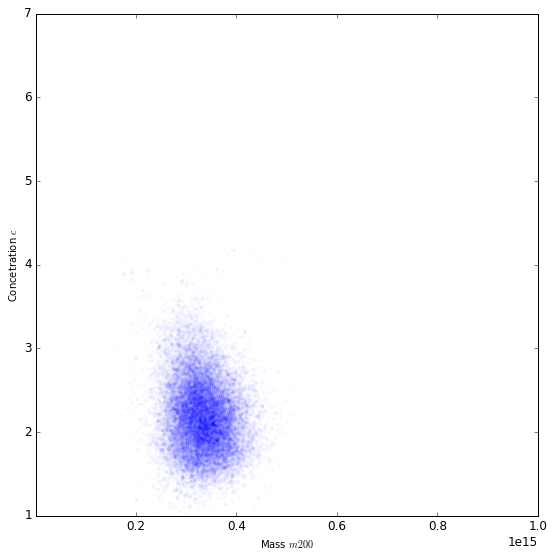

In [15]:

# First show contours from gridding calculation:
#plt.contour(m200grid, cgrid, posterior, pdf_contour_levels(posterior), colors='k')
plt.gca().set_aspect((m200limits[1]-m200limits[0])/(climits[1]-climits[0]))

# Scatterplot of m,b posterior samples, overlaid:
plt.plot(mm, cc, 'b.', alpha=0.01)
plot_mb_setup(m200limits,climits)

# Multi-dimensional Visualization

* plots to show *all 1D and 2D marginalized distributions*.

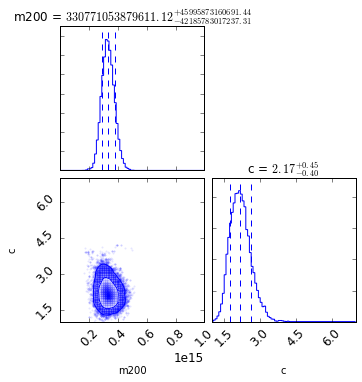

In [16]:
import corner

corner.corner(chain, labels=['m200','c'], range=[m200limits,climits],quantiles=[0.16, 0.5, 0.84],
                show_titles=True, title_args={"fontsize": 16},
                plot_datapoints=True, fill_contours=False, levels=[0.95, 0.68], 
                color='b', bins=80, smooth=1.0);

## Model Checking

* First perfoming a visual model checking...



<Container object of 3 artists>

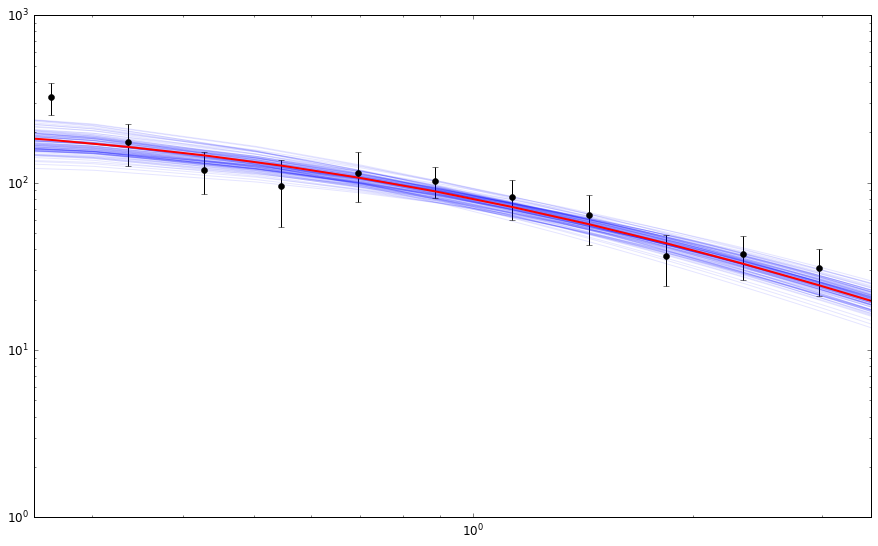

In [17]:
# Generate a straight line model for each parameter combination, and plot:

xlimits=[0.1,10.0]
X = np.linspace(xlimits[0],xlimits[1],50)
for i in (np.random.rand(100)*len(chain)).astype(int):
    m,b = chain[i]
    plt.plot(X, DStheo(X,(m,b)), 'b-', alpha=0.1)
plt.plot(R,DStheo(R,(mean_mm,mean_cc)),'r-',linewidth=2.0,label='NFW-model with MCMC')
plt.xscale('log', nonposx='clip')
plt.yscale('log', nonposy='clip')
plt.xlim(0.25,3.5)

# Overlay the data, for comparison:
plt.errorbar(R,DSobs,yerr=DSerr,label='redmapper data',fmt='ko')

In [18]:
chisq_nfw = ((-1./0.5)*nfw_log_likelihood(R, DSobs, DSerr, (mean_mm, mean_cc))) /(len(R)-2.)

print chisq_nfw

1.06514676981


# Posterior Predictive Model Checking...
* need to look the details...

# Model expansion

* Until now we try to model the WL profile by the expression: $\Delta\Sigma = \Delta\Sigma_{NFW}$, where we assumed that the matter distribution is well decribed by only a NFW 1-halo model. However, that's not exaclty the case, since we have to apply cuts in the fitting range $(0.3<R<3.5)$ to minimize the effects of the miscentering (the effect of the mis-identification of the cluster's center) and the 2-halo term (due to large scale structure, neighbor halos...)

* To take into account the miscentering term, we can rewrite our model as (put references here: J. Ford thesis, Johnston's paper...): 

$\Delta\Sigma = P_{cen} \Delta\Sigma_{NFW} + (1 - P_{cen}) \Delta\Sigma_{misc}$, 

where the $P_{cen}$ is the fraction of clusters that is correctly centered and $\Delta\Sigma_{misc}$ is the smoothed $\Delta\Sigma$ affected by the miscentering. 

* The idea to implement the miscetering term in the previous NFW 1-halo model is:
 * compute $\Delta\Sigma_{misc}$ using the clusters-lensing code: https://github.com/jesford/cluster-lensing
 * add the $P_{cen}$ parameter to the previous model that has: $\theta = (m200, c) \rightarrow \theta = (m200, c, P_{cen}) $
 * re-compute the mcmc stuffs...
 * perform the model checking
 

In [19]:
# Computing DeltaSigma_misc with clusters-lensing

import clusterlensing
from clusterlensing import ClusterEnsemble

m200_mcmc = np.array([mean_mm])
z    = np.array([z_mean])

cluster = ClusterEnsemble(z, cosmology=FlatLambdaCDM(H0=100, Om0=0.3)) 
cluster.m200 = m200_mcmc

# Checking the input values z, m200 and c200
print(cluster.dataframe.head())

rbins = R                                    # Same radial bins 

misc_off = 0.1                               # miscentering offsets in Mpc

offsets = np.ones(cluster.z.shape[0])*misc_off

cluster.calc_nfw(rbins, offsets=offsets)            # NFW with offset

dsigma_offset = cluster.deltasigma_nfw.mean(axis =0)


DSmisc = dsigma_offset.value
print(DSmisc)                         # units of M_sun/pc^2 


       z          m200        n200      r200      c200     delta_c        rs
0  0.215  3.317618e+14  120.010038  1.048529  4.258201  6055.98215  0.246237
[  69.2548521    98.8867972   136.18439938  168.73312007  190.66804301
  191.39234066  174.88848971  149.67912136  122.1166372    96.23979697
   73.7133672    55.16961324   40.47800152   29.19463215   20.74646051
   14.55353631   10.09456965    6.93283707    4.72020033    3.18923897]


In [20]:
# Defining the new likelihoods...

def new_DStheo(R, theta):
    m200,c,p_cen = theta    
    nfw = NFW(m200, c, z_mean, cosmology=FlatLambdaCDM(H0=100, Om0=0.3)) # can change cosmology, overdensity...  
    ds  = nfw.delta_sigma(R)                                             # in units of solMass/Mpc^2
    return p_cen*(np.array(ds.value/1.e12))+(1-p_cen)*DSmisc             # in units of solMass/pc^2


def nfw_misc_log_likelihood(R, DSobs, DSerr, theta):
    #print(theta)
    #m200, c = theta
    return -0.5*np.sum(( DSobs - new_DStheo(R, theta) )**2/(DSerr**2))

def nfw_misc_log_prior(theta, theta_limits):
    
    m200, c, p_cen = theta 
    
    m200limits, climits, p_cen_limits = theta_limits
    
    
    m200min, m200max = theta_limits[0][0], theta_limits[0][1] 
    cmin, cmax = theta_limits[1][0], theta_limits[1][1] 
    p_cen_min, p_cen_max = theta_limits[2][0], theta_limits[2][1] 

    

    if (m200<m200min)|(m200>m200max):
        log_m200_prior = -np.inf
    else:
        log_m200_prior = 0.0 #-np.log(m200max-m200min)
        
    if (c<cmin)|(c>cmax):
        log_c_prior = -np.inf
    else:
        log_c_prior = 0.0 #-np.log(cmax-cmin)

    if (p_cen<p_cen_min)|(p_cen>p_cen_max):
        log_p_cen_prior = -np.inf
    else:
        log_p_cen_prior = 0.0
        
        
    return log_m200_prior+log_c_prior+log_p_cen_prior
    
def nfw_misc_log_posterior(R, DSobs, DSerr, theta, theta_limits):
    m200, c, p_cen = theta
    return nfw_misc_log_likelihood(R, DSobs, DSerr, theta) + nfw_misc_log_prior(theta, theta_limits)


In [21]:
# Setting new theta limits

m200limits = [1e12, 1e15]
climits = [1, 7]
p_cen_limits = [0,1]

new_theta_limits = (m200limits, climits, p_cen_limits) 

In [22]:
# Running mcmc again...

# Initialize m200, c at the center of prior:
m200 = 0.5*(m200limits[0]+m200limits[1])
c = 0.5*(climits[0]+climits[1])
p_cen = 0.5*(p_cen_limits[0]+p_cen_limits[1])
new_theta = np.array([m200,c,p_cen])

# Step sizes, 2% or 5% of the prior
m200step = 0.02*(m200limits[1]-m200limits[0])
cstep = 0.02*(climits[1]-climits[0])
p_cen_step = 0.02*(p_cen_limits[1]-p_cen_limits[0])

stepsize = np.array([m200step,cstep, p_cen_step])        
    
# How many steps?
nsteps = 30000
   
print('Running Metropolis Sampler for', nsteps, 'steps...')

initial=clock()
new_chain, log_probs, acceptance_rate = metropolis(
    nfw_misc_log_posterior, new_theta, new_theta_limits, stepsize, nsteps=nsteps
)
final=clock()
print('Acceptance fraction:', acceptance_rate)
print('Took:', final-initial,'seconds')

('Running Metropolis Sampler for', 30000, 'steps...')
('Acceptance fraction:', 0.8982333333333333)
('Took:', 128.217436, 'seconds')


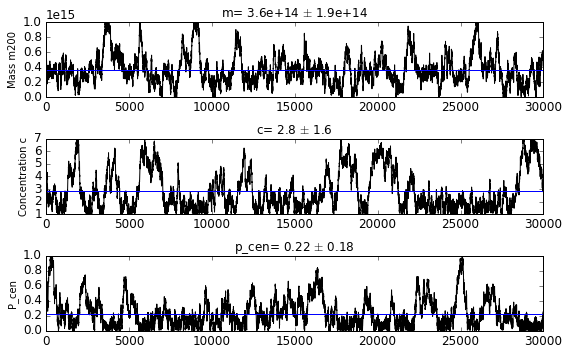

In [23]:
# new mcmc results...

# Pull m, b and q arrays out of the Markov chain and plot them:
mm = [m for m,c,p in new_chain]
cc = [c for m,c,p in new_chain]
pp = [p for m,c,p in new_chain]

length=25000 #number of points to average over (must be smaller than the number of steps) #burning ?

mean_mm = np.mean(mm[-length:])
std_mm = np.std(mm[-length:])
mean_cc = np.mean(cc[-length:])
std_cc = np.std(cc[-length:])
mean_pp = np.mean(pp[-length:])
std_pp = np.std(pp[-length:])


# Traces, for convergence inspection:
plt.figure(figsize=(8,5))
plt.subplot(3,1,1)
plt.title('m= %.2g $\pm$ %.2g'%(mean_mm,std_mm),fontsize=12)
plt.plot(mm, 'k-')
plt.axhline(np.mean(mm[-length:]))
plt.ylim(m200limits)
plt.ylabel('Mass m200')
plt.subplot(3,1,2)
plt.title('c= %.2g $\pm$ %.2g'%(mean_cc,std_cc),fontsize=12)
plt.plot(cc, 'k-')
plt.axhline(np.mean(cc[-length:]))
plt.ylim(climits)
plt.ylabel('Concentration c')
plt.subplot(3,1,3)
plt.title('p_cen= %.2g $\pm$ %.2g'%(mean_pp,std_pp),fontsize=12)
plt.plot(pp, 'k-')
plt.axhline(np.mean(pp[-length:]))
plt.ylim([p_cen_limits[0],p_cen_limits[1]])#-1.1*p_cen_limits[1],p_cen_limits[0]+1.1*p_cen_limits[1]])
plt.ylabel('P_cen')
plt.tight_layout()

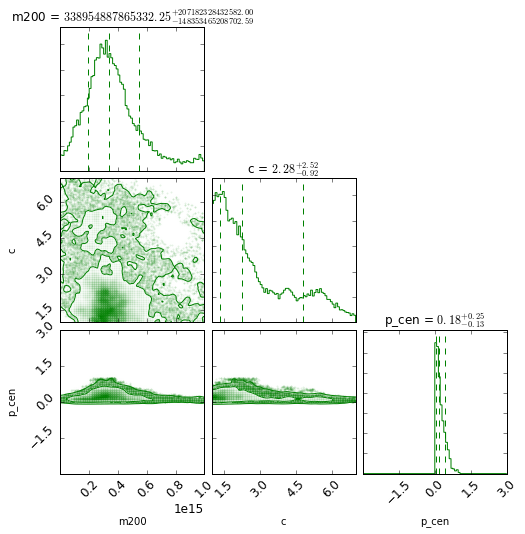

In [24]:
corner.corner(new_chain, labels=['m200','c','p_cen'], range=[m200limits,climits,(p_cen_limits[0]-3*p_cen_limits[1],p_cen_limits[0]+3*p_cen_limits[1])],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=False, levels=[0.95,0.68], 
                color='green', bins=80, smooth=1.0);

In [25]:
xlimits=[0.1,10.0]
X = np.linspace(xlimits[0],xlimits[1],100)

# new DSmisc for X bins
rbins2 = X                                    # Same radial bins 
misc_off2 = 0.1                               # miscentering offsets in Mpc
offsets2 = np.ones(cluster.z.shape[0])*misc_off
cluster.calc_nfw(rbins2, offsets=offsets2)            # NFW with offset
dsigma_offset2 = cluster.deltasigma_nfw.mean(axis =0)

DSmisc2 = dsigma_offset2.value
print(DSmisc2)                         # units of M_sun/pc^2 




[  69.2548521   165.66562702  193.3936245   180.62945252  159.09571816
  138.68936754  121.25032438  106.70049639   94.58735159   84.45083053
   75.9036437    68.6370727    62.40898786   57.02981427   52.35047103
   48.25289225   44.64281347   41.44433917   38.59585481   36.0469382
   33.75601123   31.68854105   29.81565143   28.11304192   26.56014023
   25.13943218   23.83592827   22.63673595   21.53071439   20.50819403
   19.56074733   18.68100043   17.86247741   17.0994709    16.38693413
   15.72039034   15.09585638   14.5097782    13.95897594   13.44059716
   12.95207672   12.49110242   12.05558529   11.64363399   11.25353249
   10.88372075   10.5327778    10.19940699    9.88242299    9.58074039
    9.29336351    9.01937817    8.75794281    8.50828217    8.26968091
    8.04147812    7.82306232    7.61386705    7.41336693    7.22107407
    7.03653488    6.85932721    6.68905768    6.5253594     6.36788979
    6.21632867    6.0703765     5.92975279    5.79419466    5.66345547
    5.5

<Container object of 3 artists>

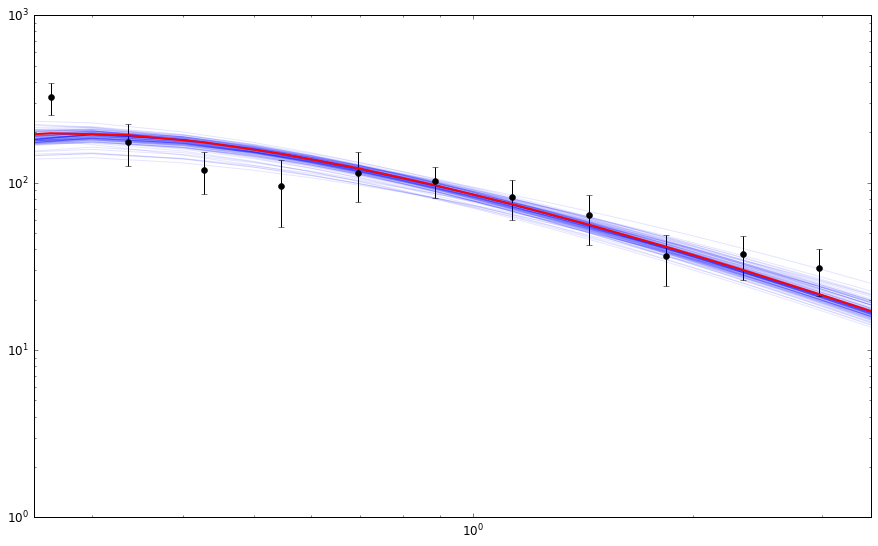

In [26]:
def new_DStheo2plot(R, theta):
    m200,c,p_cen = theta    
    nfw = NFW(m200, c, z_mean, cosmology=FlatLambdaCDM(H0=100, Om0=0.3)) # can change cosmology, overdensity...  
    ds  = nfw.delta_sigma(R)                                             # in units of solMass/Mpc^2
    return p_cen*(np.array(ds.value/1.e12))+(1-p_cen)*DSmisc2             # in units of solMass/pc^2


for i in (np.random.rand(100)*len(new_chain)).astype(int):
    m,c,p = new_chain[i]
    plt.plot(X, new_DStheo2plot(X, (m,c,p)), 'b-', alpha=0.1)
plt.plot(R,new_DStheo(R, (mean_mm,mean_cc,mean_pp)),'r-',linewidth=2.0,label='NFW-model with MCMC')
plt.xscale('log', nonposx='clip')
plt.yscale('log', nonposy='clip')
plt.xlim(0.25,3.5)

# Overlay the data, for comparison:
plt.errorbar(R,DSobs,yerr=DSerr,label='redmapper data',fmt='ko')


In [27]:
chisq_nfw_misc = ((-1./0.5)*nfw_misc_log_likelihood(R, DSobs, DSerr, (mean_mm, mean_cc,mean_pp))) /(len(R)-3.)

print chisq_nfw_misc

1.14419751014
